# 2.6 Simulación de variables aleatorias
Probabilidad 1\
Semestre 2023-2\
Por: Jorge Iván Reyes Hernández\
Facultad de Ciencias, UNAM

En este Notebook revisaremos brevemente un par de resultados que nos ayudarán a generar números aleatorios de diversas distribuciones. Comenzamos definiendo qué es una sucesión de números aleatorios uniformemente distribuidos en el intervalo $[0,1]$.

**Definición**. 
Una sucesión $\{ x_n \}_{n\in \mathbb{N}^{+}}$ de números reales en el intervalo $[0,1]\subset \mathbb{R}$ es una sucesión de números aleatorios si existen
1. Un espacio de probabilidad $(\Omega, \mathcal{F}, P)$,
2. Una sucesión $\{ U_n \}_{n\in \mathbb{N}^{+}}$ de variables aleatorias independientes e idénticamente distribuidas con distribución $\mathbf{U}([0,1])$, y
3. $\omega \in \Omega$ tal que $\forall n \in \mathbb{N}^{+}$, $x_n = U_n(\omega)$.

---

Intuitivamente, podemos pensar en números aleatorios uniformemente distribuidos como las realizaciones de variables aleatorias uniformes. 

Más adelante veremos que una consencuencia del _Principio fundamental de la simulación_ es que cualquier variable aleatoria puede ser simulada usando únicamente la distribución uniforme en $[0,1]$. Por lo anterior, el problema de simular variables aleatorias se reduce a saber cómo simular variables aleatorias uniformes (es decir, cómo generar números aleatorios uniformemente distribuidos en $[0,1]$).

## Un generador lineal congruencial

Un procedimiento usual para generar números (pseudo)-aleatorios es generar números enteros $y_n$ a través de la relación congruencial de recurrencia,

$$
\begin{equation}
    y_{n+1}  \equiv a y_n + b \hspace{0.5 cm} \text{mod } N
\end{equation}
$$

y luego construir la sucesión de números pseudo-aleatorios como sigue,

$$
    x_{n} = \frac{y_n}{N}, \hspace{0.5 cm} y_n \in \{0, \dots, N-1 \}
$$

donde $mcd(a, N) = 1$ (es decir, $a$ y $N$ son primos relativos). Note que por construcción, $x_n \in [0,1)$ para toda $n$, por lo que son buenos candidatos para ser números (pseudo)-aleatorios uniformemente distribuidos en $(0,1)$.

La parte fina del generador lineal congruencial es saber elegir valores de $a, b$ y $N$ adecuados. Para ver los detalles teóricos véase [1].

## Mersenne Twister + Lehmer

Por simplicidad, optaremos por hacer un generador lineal congruencial siguiendo algunas ideas del generador [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister) y del generador de [Lehmer](https://en.wikipedia.org/wiki/Lehmer_random_number_generator).

El generador Lehmer supone que $b=0$, y el generador Mersenne Twister que $N$ es un número primo de Mersenne. Además necesitamos que $mcd(y_0, N) = 1$ y que el orden multiplicativo módulo N de $a$ sea grande (aunque esto es importante para obtener el mayor periodo, no es obligatorio).

La relación congruencial de recurrencia se reduce a,

$$
\begin{equation}
    y_{n+1}  \equiv a y_n  \hspace{0.5 cm} \text{mod } N
\end{equation}
$$

con $N = 2 ^{p} - 1$ con $p$ un número primo. Al valor inicial $y_0$ se le conoce como semilla (seed, en inglés).

In [1]:
from math import gcd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
class RandomGenerator:
    def __init__(self, seed, N=(2**43)-1, a=321456, b=0):
        """
        :param N: Módulo. Un número primo de Mersenne. Por defecto, p = 43, N = 2^{p} - 1
        :param a: Magnitud.
        :param b: Salto. Por defecto su valor es 0 (Lehmer generator).
        :param seed: Semilla para generar el valor inicial.
        """
        # Verificamos que a y X_0 sean primos relativos con N.
        assert gcd(N, a) == 1, print(f"mcd({a},{N}) != 1")
        assert gcd(N, seed) == 1, print(f"mcd({seed},{N}) != 1")
        
        self.y_0 = seed
        self.__N = N
        self.__a = a
        self.__b = b
    
    def generate(self, size):
        """ Genera un arreglo con self.size números pseudo-aleatorios con 
            distribución uniforme.
            
        :param size: Tamaño de la muestra.
        """
        # Arreglo de tamaño self.size para guardar los números generados.
        U = np.zeros(size)
        
        # Primer elemento y = y_1 = a * y_0 + b  mod N.
        y = (self.__a * self.y_0 + self.__b) % self.__N
        
        # Dividimos por N y guardamos en el arreglo.
        U[0] = y / self.__N

        # Construimos los demás elementos
        for i in range(1, size):
            y = (self.__a * y + self.__b) % self.__N
            U[i] = y / self.__N
            
        return U

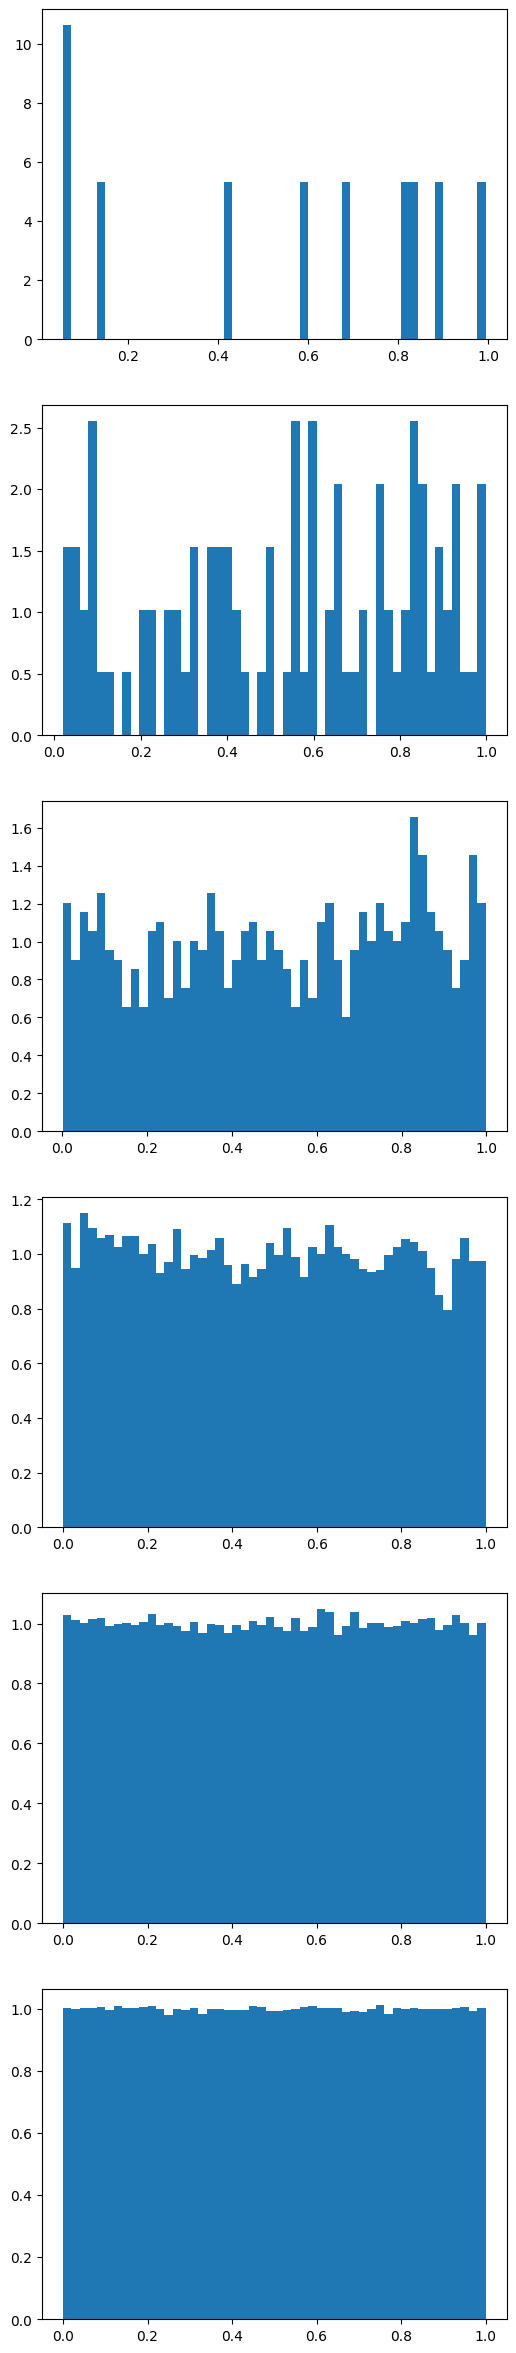

In [3]:
# Probamos el generador

fig, ax = plt.subplots(6, 1)
fig.set_figwidth(6)
fig.set_figheight(30)

sizes = [10 ** i for i in range(1,7)]
generator = RandomGenerator(seed=12332145654)

for i in range(len(sizes)):
    unif_custom = generator.generate(size=sizes[i])
    ax[i].hist(unif_custom, density=True, bins=50)
    plt.plot()

Como podemos ver, los números generados se aproximan más a números aleatorios conforme el tamaño de la muestra crece.

## El teorema fundamental de la simulación

El siguiente teorema es la base teórica de todo lo que haremos en lo sucesivo.

**Teorema (fundamental de la simulación).** Sea $(\mathbb{R}, d_E)$  un espacio topológico completamente metrizable y separable, y sea 

$$
    X:(\Omega, \mathcal{F}, P) \to (\mathbb{R}, \mathcal{B}(\mathbb{R}), \mathbb{P})
$$

una variable aleatoria con distribución $\mathbb{P}$. Entonces existe una función borel medible 

$$
    \varphi : ([0,1], \mathcal{B}([0,1]), \lambda_{[0,1]}) \to (\mathbb{R}, \mathcal{B}(\mathbb{R}), \mathbb{P})
$$

tal que

$$
    \mathbb{P} = \lambda_{[0,1]} \circ \varphi ^{-1}
$$

donde $\lambda_{[0,1]} \circ \varphi ^{-1}$ denota la imagen de $\varphi$ bajo la medida de Lebesgue $\lambda_{[0,1]}$ en el intervalo $[0,1]$.

---

Lo que nos interesa del teorema anterior es el siguiente,

**Corolario** Si $U$ es una variable aleatoria con distribución uniforme en $[0,1]$ definida en el espacio de probabilidad $(\Omega, \mathcal{F}, P)$, entonces dada cualquier variable aleatoria $X$, existe una función borel-medible tal que,
$$
    X \overset{d}{=} \varphi(U)
$$

---

Es decir, podemos partir de números aleatorios uniformemente distribuidos en $[0,1]$, $u_i$, aplicarles una transformación apropiada, $\varphi$, y generar números aleatorios con cualquier otra distribución, $x_i = \varphi(u_i)$. Note que la elección de $\varphi$ dependerá de la distribución de $X$.

## Simulación de variables aleatorias

Ya sabemos cómo simular números pseudo-aleatorios con distribución uniforme en $[0,1]$ (véase la clase _RandomGenerator_), entonce sólo basta encontrar funciones $\varphi$ adecuadas para generar otras variables aleatorias. El ejemplo más sencillo es el de la distribución Bernoulli, $Ber(p)$.

### Distribución Bernoulli
Queremos simular números aleatorios que sigan una distribución $Ber(p)$, $p \in (0,1)$.

Para cada $p \in (0,1)$, considere $A_p = \{y \in \mathbb{R}: y \leq p \}$ y defina la función $\varphi : [0,1] \to \mathbb{R}$, dada por

$$
\begin{align*}
    \varphi(x) &= \mathbf{1}_{A_p}(x)\\
               &= \begin{cases} 
                  1 &\text{ si } x \in A_p\\
                  0 &\text{ si } x \notin A_p\\
                  \end{cases}\\
               &= \begin{cases} 
                  1 &\text{ si } x \leq p \\
                  0 &\text{ si } x > p \\
               \end{cases}\\
\end{align*}
$$

Entonces, 

$$
\begin{align*}
    X(\omega) &= \varphi(U(\omega))\\
              &= \begin{cases} 
                  1 &\text{ si } U(\omega) \leq p \\
                  0 &\text{ si } U(\omega) > p \\
               \end{cases}\\
\end{align*}
$$

Note que la variable aleatoria $X$ tiene dos resultados, $0$ y $1$, además $\mathbb{P}(X=1) = \mathbb{P}(U \leq p) = p$, por lo que $X$ tiene distribución $Ber(p)$

In [4]:
def ber(p, size, seed=96325874101):
    """ Función que simula números aleatorios con distribución Ber(p).
    
    :param p: Parámetro de éxito en el ensayo bernoulli.
    :para size: Tamaño de la muestra.
    :return: Arreglo con @param:size números pseudo-aleatorios con distribución ber(p)
    """
    
    assert 0 <= p <= 1
    assert size > 0
    
    # Arreglo para guardar los números aleatorios con distribución Ber(p)
    X = np.zeros(size, dtype=int)
    
    # Generamos tantos números uniformemente distribuidos como elementos bernoulli queramos
    U = RandomGenerator(seed=seed).generate(size=size)
    
    for i in range(size):        
        if U[i] <= p:
            X[i] = 1
        else:
            X[i] = 0
            
    return X

In [5]:
# Probamos nuestra función

ber_sample = ber(0.5, 120)
ber_sample


array([1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0])

In [6]:
# Verificamos que aproximadamente la mitad de la muestra sea 1.

bin = sum(ber_sample)


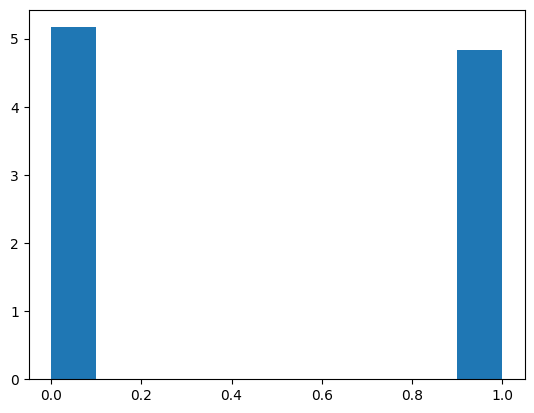

In [7]:
# Hacemos un histograma para ver la densidad empírica de la muestra

plt.hist(ber_sample, density=True);



### Distribución Binomial
Queremos simular números aleatorios que sigan una distribución $Bin(n,p)$, $n \geq 1$, $p \in (0,1)$.

Esto es relativamente fácil de hacer, pues sabemos que si tenemos $X_1, \dots X_n \sim Ber(p)$, entonces 

$$
\sum _{i=1}^{n} X_i \sim Bin(n,p)
$$

In [8]:
def binom(n, p, size):
    """ Función para simular números pseudo-aleatorios con distribución binom(n, p)
    
    :param n: Parámetro n >= 1
    :param p: Parámetro de éxito en los ensayos bernoulli.
    :param size: Tamaño de la muestra.
    :return: Arreglo con @param:size números pseudo-aleatorios con distribución binom(n,p)
    """
    assert n >= 1
    assert 0 <= p <= 1
    assert size > 0
    
    # Arreglo para guarda los números con distribución bin(n, p)
    Y = np.zeros(size, dtype=int)
    
    # Arreglo con semillas para generar varias muestras
    seeds = [123**i for i in range(size)]
    
    for i in range(size):
        X = ber(p, n, seed=seeds[i])
        Y[i] = np.sum(X)
    
    return Y

In [9]:
# Probamos nuestra función
binom_sample = binom(16, 0.5, size=10000)
binom_sample

array([10,  8,  9, ..., 10,  4,  6])

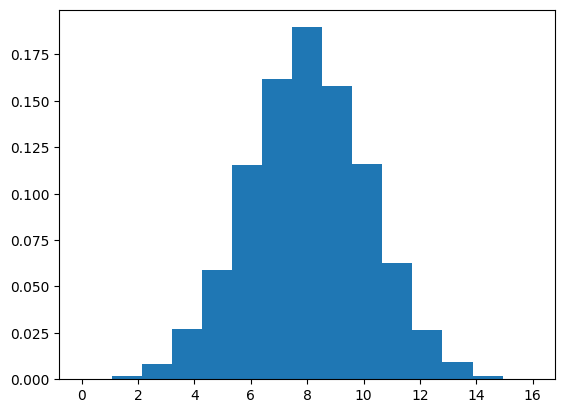

In [10]:
plt.hist(binom_sample, density=True, bins=15);


---

**Ejercicios**
1. Sea $U$ una variable aleatoria uniforme en $[0, 1]$. Sean $a,b \in \mathbb{R}$, $a < b$ dos constantes. Se puede demostrar que la variable aleatoria 
$$
    X = \varphi(U) = a + (b-a)U
$$ 
tiene distribución uniforme en el intervalo $[a,b]$. Genere $n = 500,000$ números pseudo-aleatorios (usando la clase _RandomGenerator_ y la función $\varphi$ adecuada) con distribución uniforme en el intervalo $[a,b]$. Construya un histograma para esta muestra.

In [11]:
# Tu solución


2. Sea $U$ una variable aleatoria con distribución uniforme en el intervalo $[0, 1]$. Sea $\lambda > 0$ una constante y defina la siguiente transformación, 
$$ 
X = \varphi(U) = -\frac{1}{\lambda}\ln{(1-U)}
$$ 
Demuestre que $X \sim \exp(\lambda)$. Además genere $n = 500,000$ números pseudo-aleatorios (usando la clase _RandomGenerator_ y la función $\varphi$ adecuada) con distribución $\exp(\lambda)$. Construya un histograma para esta muestra.

In [12]:
# Tu solución


3. Investiga qué transformaciones son adecuadas para generar números pseudo-aleatorios con distribución $N(0,1)$. Genera $n=10,000$ números con esta distribución (usando la clase _RandomGenerator_ y las transformaciones adecuadas). Construye un histograma con esta muestra y grafícalo junto a la función de densidad correspondiente. ¿Cómo determinarías qué tan bien se aproxima el histograma a la función de densidad?

Hints:
- George Edward Pelham __Box__ y Mervin Edgar __Müller__ podrían ayudarte.
- El segundo problema es conocido como _Bondad de ajuste_.

In [13]:
# Tu solución


---

# Referencias
[1]. Pagès, Gilles, Numerical Probability An Introduction with Applications to Finance, Springer, 2018.\
[2]. Rincón, Luis, Introducción a la probabilidad, La Prensa de Ciencias, 2014.